In [3]:
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [47]:
# generate random data of shape (14, N, 18, 14)
def generate_random_data(N, spike_value=100):
    # start with completey random noise (integers between 0 and 10)
    X = np.random.randint(low=0, high=10, size=(14, N, 18, 14))

    # add random spikes along each eta slice
    for eta in range(14):
        spikey_col = np.random.randint(low=0, high=spike_value, size=(N, 18))
        X[eta, :, :, eta] += spikey_col

    return X

X = generate_random_data(N=10_000, spike_value=100)



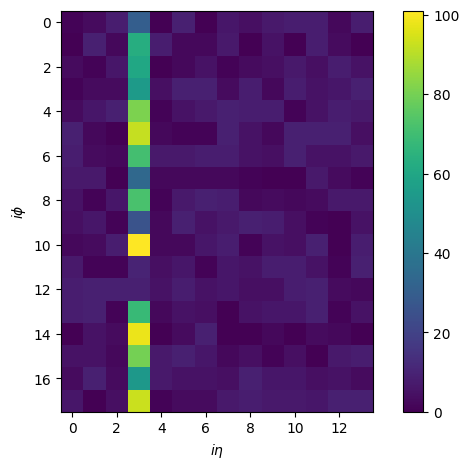

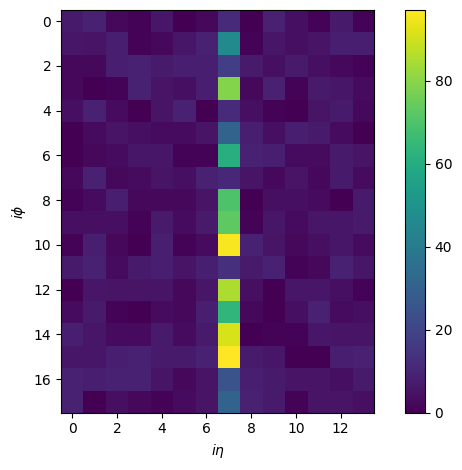

In [48]:
# plot some example images to check
# should be random noise with a column at eta=eta_idx that is spikey
def plot_example(X, eta_idx, evt_idx):
    plt.imshow(X[eta_idx, evt_idx])
    plt.colorbar()
    plt.xlabel(rf"$i\eta$")
    plt.ylabel(rf"$i\phi$")
    plt.tight_layout()
    plt.show()

plot_example(X, 3, 0)
plot_example(X, 7, 42)


In [49]:
# load the models & create Baseline helper model
class BaseLine:
    """
    baseline model that predicts the sum of the squares of the input
    scaled down to roughly match cicada scores (absoulte values dont matter)
    """
    def predict(self, X, batch_size=None, verbose=None):
        """predict() method w/ same signature as Keras model"""
        return np.mean(X ** 2, axis=1) / 2

model_dict = {
    "base-line": BaseLine(),
    "cicada-v2.1.2": load_model("models/from-eos/cicada-v2"),
    "cicada-v2.2.0": load_model("models/2025-02-04/best-legacy-method"),
 }


In [69]:
# calculate anomaly scores for each model

def get_score_dict(model_dict, X):
    score_dict = {
        name: np.zeros((14, X.shape[1])) for name in model_dict.keys()
    }

    for name, model in model_dict.items():
        for eta in range(14):
            X_ = X[eta, ...].reshape((-1, 252))
            scores = model.predict(X_, batch_size=512, verbose=False).flatten()
            score_dict[name][eta, :] = scores

    # scale the base-line scores to roughly match the cicada scores
    cic_mean = (np.mean(score_dict["cicada-v2.1.2"]) + np.mean(score_dict["cicada-v2.2.0"])) / 2
    scale_factor = cic_mean / np.mean(score_dict["base-line"])
    score_dict["base-line"] *= scale_factor

    return score_dict

score_dict = get_score_dict(model_dict, X)


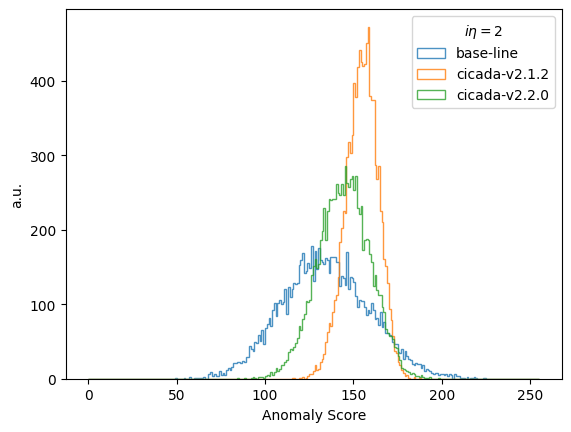

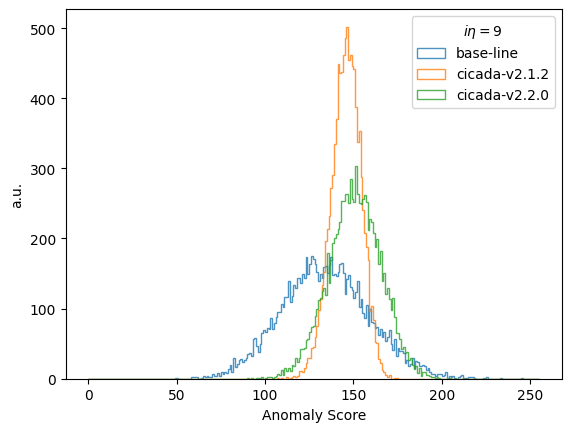

In [70]:
# plot scores for different eta slices

def plot_scores_for_eta(score_dict, eta):
    for name, scores in score_dict.items():
        plt.hist(scores[eta], bins=range(256), histtype='step', label=name, alpha=0.8)
    plt.xlabel('Anomaly Score')
    plt.ylabel('a.u.')
    plt.legend(title=rf"$i\eta = {eta}$")
    plt.show()

plot_scores_for_eta(score_dict, 2)
plot_scores_for_eta(score_dict, 9)


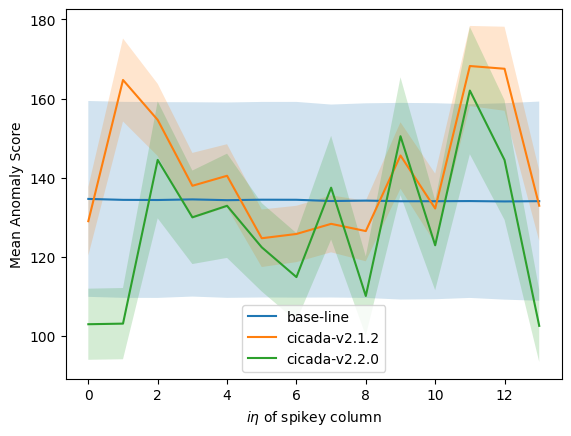

In [75]:
# let's plot the mean score as a function of eta
def plot_mean_scores(score_dict, title=None):
    for name, scores in score_dict.items():
        means = np.mean(scores, axis=1)
        stds = np.std(scores, axis=1) 
        plt.plot(range(14), means, label=name)
        plt.fill_between(range(14), means - stds, means + stds, alpha=0.2)
    plt.title(title)
    plt.xlabel(rf"$i\eta$ of spikey column")
    plt.ylabel("Mean Anomaly Score")
    plt.legend()
    plt.show()

plot_mean_scores(score_dict)


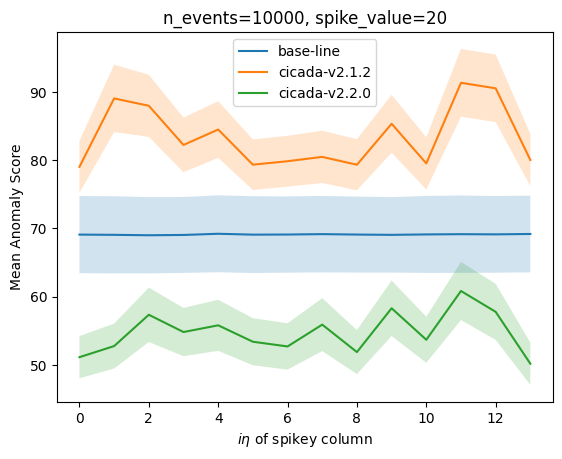

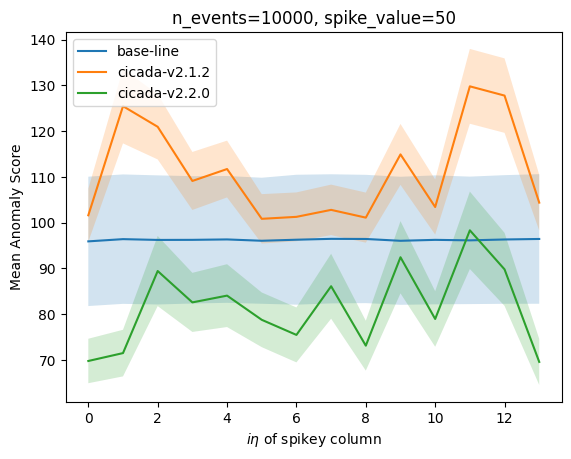

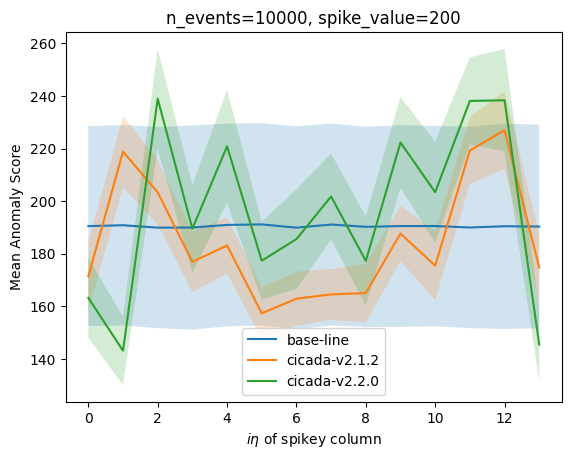

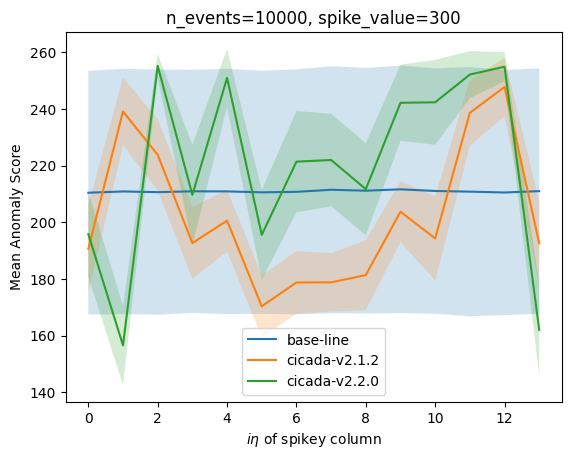

In [76]:
# let's put it all together and see how different spike values affect the scores
def run_pipeline(n_events=10_000, spike_value=100):
    X = generate_random_data(n_events, spike_value=spike_value)
    score_dict = get_score_dict(model_dict, X)
    plot_mean_scores(score_dict, title=rf"n_events={n_events}, spike_value={spike_value}")

run_pipeline(n_events=10_000, spike_value=20)
run_pipeline(n_events=10_000, spike_value=50)
run_pipeline(n_events=10_000, spike_value=200)
run_pipeline(n_events=10_000, spike_value=300)
